In [17]:
import pandas as pd
import datetime
from tqdm import tqdm
import re
import optuna
import operator
import numpy as np
import matplotlib.pyplot as plt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
import requests
from datetime import timedelta
import pickle
from sklearn.linear_model import LinearRegression

<IPython.core.display.Javascript object>

In [18]:
def test_live(sample_duration):
    def vn30f():
        return requests.get("https://services.entrade.com.vn/chart-api/chart?from=1651727820&resolution=1&symbol=VN30F1M&to=9999999999").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    s = pd.read_csv('C:\python\VN30F1M.csv')
    s['Date'] = pd.to_datetime(s['Date']) + timedelta(hours =7)
    ohlc_dict = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                                                                        
        'Close': 'last',                                                                                                    
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    def process_data(input_df):
        vn30train = pd.DataFrame(input_df.resample(str(sample_duration)+'Min', on='Date', label='left').apply(ohlc_dict).dropna()).reset_index()#change s
        vn30train['Date'] = [str(i)[:16] for i in vn30train['Date']]
        return vn30train
    vn30f_base = pd.concat([process_data(vn30fm), process_data(s)]).sort_values('Date').drop_duplicates('Date').sort_values('Date')
    return vn30f_base

In [19]:
data = test_live(15)

def create_ds(data):
    data.Date = pd.to_datetime(data.Date)
    dff = data[['Date', 'Open']]
    #dff['Date'] = pd.to_datetime(dff['Date'])
    dff['Date'].apply(lambda x:x.hour)
    df1 = dff.loc[(dff['Date'].apply(lambda x:x.minute)==00)&(dff['Date'].apply(lambda x:x.hour)==9)]
    df1.Date = [str(i)[:10] for i in df1.Date]

    df = data[['Date', 'Close']]
    #df['Date'] = pd.to_datetime(df['Date'])
    df['Date'].apply(lambda x:x.hour)
    df2 = df.loc[(df['Date'].apply(lambda x:x.minute)==15)&(df['Date'].apply(lambda x:x.hour)==9)]
    df2.Date = [str(i)[:10] for i in df2.Date]
    #df 9:30
    df3 = df.loc[(df['Date'].apply(lambda x:x.minute)==30)&(df['Date'].apply(lambda x:x.hour)==9)]
    df3.Date = [str(i)[:10] for i in df3.Date]
    #df 10:00
    df4 = df.loc[(df['Date'].apply(lambda x:x.minute)==00)&(df['Date'].apply(lambda x:x.hour)==10)]
    df4.Date = [str(i)[:10] for i in df4.Date]
    #ds
    ds = df1.merge(df2, how = 'inner', on = 'Date').merge(df3, how = 'inner', on = 'Date').merge(df4, how = 'inner', on = 'Date')
    ds.columns = ['Date', 'Open', '9:15', '9:30', '10:00']
    # find_low to merge to ds
    df10 = data[['Date', 'Low']]
    df10['Date'] = pd.to_datetime(df10['Date'])
    
    findlow = df10.loc[(df10['Date'].apply(lambda x:x.hour)>10)]
    findlow['Day'] = [str(i)[:10] for i in findlow.Date]

    data['Day'] = [str(i)[:10] for i in data.Date]
    low = findlow[['Day','Low']].groupby('Day').min()
    #high = data[['Day','High']].groupby('Day').max()
    #high['Date'] = high.index

    low['Date'] = low.index
    ds = ds.merge(low, how='left', on='Date')
    
    return ds
ds = create_ds(data)
ds

C:\Users\Admin\AppData\Local\Temp\ipykernel_9332\236629776.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.Date = [str(i)[:10] for i in df1.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_9332\236629776.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Date = [str(i)[:10] for i in df2.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_9332\236629776.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

Date    Open    9:15    9:30   10:00     Low
0     2017-08-14   745.7   746.2   747.0   746.1   746.1
1     2017-08-15   750.8   749.4   749.6   750.3   748.0
2     2017-08-16   747.3   747.1   745.7   747.0   745.7
3     2017-08-17   749.0   748.2   747.6   748.0   744.5
4     2017-08-21   742.9   742.6   742.4   742.1   741.6
...          ...     ...     ...     ...     ...     ...
1360  2023-01-18  1105.0  1107.8  1110.5  1108.8  1108.7
1361  2023-01-19  1114.0  1116.3  1119.2  1122.8  1115.3
1362  2023-01-27  1138.9  1141.2  1140.5  1138.7  1123.8
1363  2023-01-30  1125.5  1123.6  1123.7  1126.5  1109.8
1364  2023-01-31  1108.5  1104.2  1106.5  1107.4  1097.6

[1365 rows x 6 columns]

In [20]:
def create_XY(ds):
    X = ds.drop(['Low', 'Date'], axis = 1)
    Y = ds['Low']
    X_train = X.loc[:900]
    X_test = X.loc[900:]
    Y_train = Y.loc[:900]
    Y_test = Y.loc[900:]
    return X_train, Y_train, X_test, Y_test
X_train, Y_train, X_test, Y_test = create_XY(ds)
X_test

Open    9:15    9:30   10:00
900   1208.0  1207.3  1208.7  1204.9
901   1195.7  1193.3  1193.0  1194.9
902   1178.2  1174.9  1176.1  1176.8
903   1172.0  1171.3  1166.4  1167.1
904   1164.3  1168.3  1167.3  1167.0
...      ...     ...     ...     ...
1360  1105.0  1107.8  1110.5  1108.8
1361  1114.0  1116.3  1119.2  1122.8
1362  1138.9  1141.2  1140.5  1138.7
1363  1125.5  1123.6  1123.7  1126.5
1364  1108.5  1104.2  1106.5  1107.4

[465 rows x 4 columns]

Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

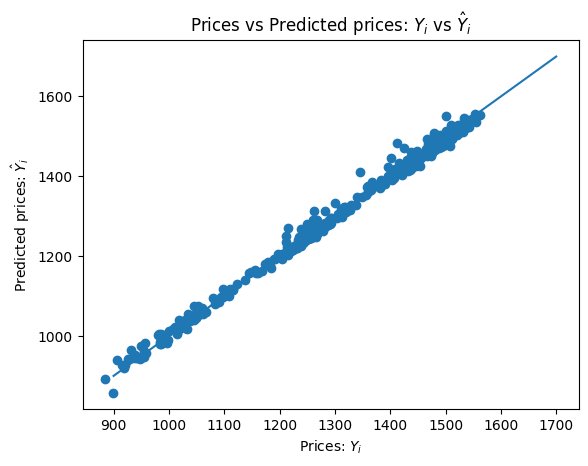

In [21]:
lm = pickle.load(open('finalized_model.sav', 'rb'))
Y_pred = lm.predict(X_test)
x = np.linspace(900, 1700, 100000)
plt.plot(x, x)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [22]:
Y_pred

array([1192.47893379, 1184.62598471, 1165.95074076, 1156.83774034,
       1158.58523956, 1163.31216266, 1170.75416467, 1192.75316794,
       1203.95408887, 1232.36411758, 1244.95078732, 1243.50244719,
       1242.82451196, 1241.47371503, 1239.40301435, 1248.13228306,
       1290.49598798, 1269.51786789, 1274.04893256, 1274.48436082,
       1262.53228636, 1311.90392969, 1290.28985521, 1265.55914009,
       1280.78788081, 1245.87697831, 1269.94569831, 1279.94730614,
       1282.97278933, 1327.66101342, 1320.8165962 , 1319.90932198,
       1327.61935891, 1347.27425293, 1347.4006214 , 1369.30711269,
       1376.51136896, 1366.00371894, 1364.81221022, 1370.80350955,
       1394.59701051, 1396.5040579 , 1411.49970525, 1412.74894434,
       1427.22975283, 1441.47464069, 1426.77309145, 1425.89600308,
       1468.05438135, 1479.68247172, 1474.26310306, 1495.39284025,
       1482.28006915, 1483.13386005, 1427.34096241, 1460.55057253,
       1451.65288069, 1484.15948619, 1478.76168852, 1458.15835

In [23]:
def create_y_test(data, Y_test, Y_pred):
    Y_test = pd.DataFrame(Y_test)
    Y_test['pred'] = Y_pred

    ope = data[['Date', 'Open']]
    ope['Date'] = pd.to_datetime(ope['Date'])
    ope['Date'].apply(lambda x:x.hour)
    op = ope.loc[(ope['Date'].apply(lambda x:x.minute)==15)&(ope['Date'].apply(lambda x:x.hour)==10)]
    op.Date = [str(i)[:10] for i in op.Date]

    Y_test['Date'] = ds.Date.iloc[900:]
    Y_test = Y_test.merge(op, how='inner', on='Date')
    Y_test.drop('Date', axis = 1)
    Y_test['dev'] = Y_test.pred - Y_test.Open
    Y_test['Date'] = [str(i)+ ' 10:15' for i in Y_test.Date]
    Y_test.Date = [str(i) for i in Y_test.Date]
    Y_test['accu'] = (Y_test.Low - Y_test.pred)
    Y_test.Date = pd.to_datetime(Y_test.Date)
    return Y_test
Y_test = create_y_test(data, Y_test, Y_pred)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9332\3565763201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ope['Date'] = pd.to_datetime(ope['Date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_9332\3565763201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op.Date = [str(i)[:10] for i in op.Date]


In [24]:
def create_signal(Y_test, data):
    sig = Y_test[['Date', 'dev']]
    signal = pd.DataFrame()
    signal = data.merge(sig, how='left', on='Date')
    signal = signal.fillna(110)

    ok = Y_test[['Date', 'pred']]
    signal = signal.merge(ok, how='left', on='Date')
    signal = signal.fillna(method='pad')
    return signal
signal = create_signal(Y_test, data)

In [25]:
signal

Date    Open    High     Low   Close   Volume  \
0     2017-08-10 09:15:00   757.9   757.9   755.5   755.5     26.0   
1     2017-08-10 09:30:00   755.1   755.1   753.8   753.8     21.0   
2     2017-08-10 09:45:00   753.6   753.6   752.3   752.3     13.0   
3     2017-08-10 10:00:00   752.0   752.0   750.4   750.4     17.0   
4     2017-08-10 10:15:00   750.0   750.0   748.2   748.2     20.0   
...                   ...     ...     ...     ...     ...      ...   
25904 2023-01-31 14:15:00  1108.9  1126.0  1108.1  1126.0  31265.0   
25905 2023-01-31 14:30:00  1126.0  1126.0  1126.0  1126.0     64.0   
25906 2023-01-31 14:45:00  1125.0  1125.0  1125.0  1125.0   7621.0   
25907 2023-02-01 09:00:00  1129.8  1130.5  1126.5  1126.7  13027.0   
25908 2023-02-01 09:15:00  1126.8  1127.0  1126.7  1127.0    584.0   

              Day    dev         pred  
0      2017-08-10  110.0          NaN  
1      2017-08-10  110.0          NaN  
2      2017-08-10  110.0          NaN  
3      2017-08-10  110.0          NaN  
4      2017-08-10  110.0          NaN  
...           ...    ...          ...  
25904  2023-01-31  110.0  1097.317085  
25905  2023-01-31  110.0  1097.317085  
25906  2023-01-31  110.0  1097.317085  
25907  2023-02-01  110.0  1097.317085  
25908  2023-02-01  110.0  1097.317085  

[25909 rows x 9 columns]

In [26]:
buy = 0
profit = []
date = []
position = []
buy1=0
hi =10
time = []
buyl = 0
cash = 1
for i in tqdm(range(len(signal))):
    if buy == 0 and hi == 10 and signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-4] < -1.5:
        buy = signal.Open.iloc[i] - 0.075
        position.append(-1)
        # position.append(-cash/buy)
        #info = posi("pos=-1\ntime=1")
        #time = i
        date.append(signal.Date.iloc[i])
    if buyl == 0 and buy == 0 and hi == 10 and signal.dev.iloc[i] < 50 and signal.Open.iloc[i] - signal.Close.iloc[i-4] > 5 and profit[-1] > -3:
        buyl = signal.Open.iloc[i]
        # position.append(cash/buyl)
        position.append(1)
        date.append(signal.Date.iloc[i])

    if buy != 0 and ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==45):
            profit.append(buy - signal.Open.iloc[i])
            cash = cash + (buy - signal.Open.iloc[i])/buy
            time.append(signal.Date.iloc[i])
            date.append(signal.Date.iloc[i])
            buy1 = signal.Open.iloc[i] + 0.075
            # position.append(cash/buy1)
            position.append(1)
            #info = posi("pos=1\ntime=1")
            buy = 0
            hi = 0
    if hi == 0 and buy1 != 0:
        if ((signal.Date.iloc[i]).hour == 9 and (signal.Date.iloc[i]).minute==00 and signal.Open.iloc[i]-buy1 < -5) or (signal.Date.iloc[i]).hour == 10 and (signal.Date.iloc[i]).minute==00:
            position.append(0)
            #info = posi("pos=0\ntime=1")
            profit.append(signal.Open.iloc[i]-buy1)
            cash = cash + (signal.Open.iloc[i]-buy1)/buy1
            time.append(signal.Date.iloc[i])
            date.append(signal.Date.iloc[i])
            hi = 10
    if buyl != 0 and signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-4] < -1.5:
        profit.append(signal.Open.iloc[i]-buyl)
        cash = cash + (signal.Open.iloc[i]-buyl)/buyl
        time.append(signal.Date.iloc[i])
        buy = signal.Open.iloc[i] - 0.075
        position.append(-1)
        # position.append(-cash/buy)
        #info = posi("pos=-1\ntime=1")
        #time = i
        date.append(signal.Date.iloc[i])
        buyl = 0
haha = pd.DataFrame()
haha['Date'] = date
haha['pos'] = position
short = data.merge(haha, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)

pnl_report = pd.DataFrame()
pnl_report['Date'] = time
pnl_report['gain'] = profit
pnl_report = pnl_report.set_index('Date').resample("D").sum().dropna().reset_index()
pnl_report['index'] = range(len(pnl_report))
pnl_report.set_index('index', inplace=True)
# pnl_report = pnl_report[pnl_report.index > 596]
pnl_report = pnl_report.loc[pnl_report['Date'].apply(lambda x:x.weekday()) < 5]
pnl_report['total_gain'] = pnl_report.gain.cumsum()

100%|██████████| 25909/25909 [00:00<00:00, 30878.71it/s]


<AxesSubplot:>

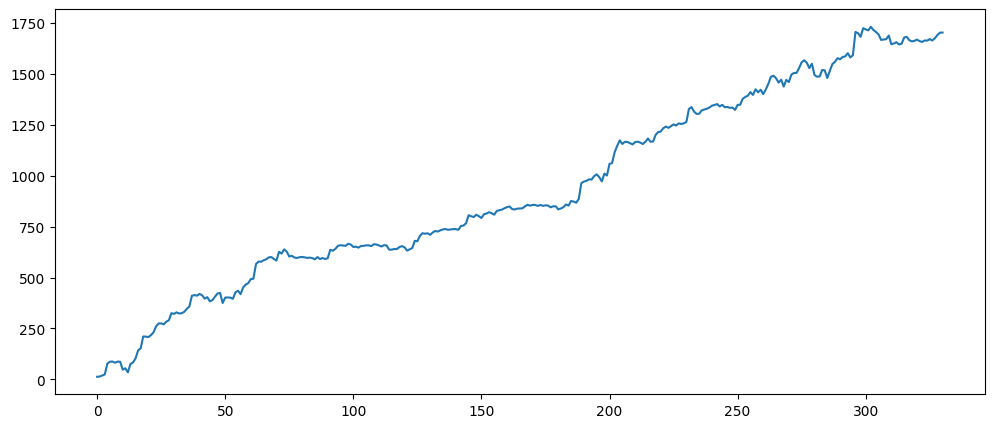

In [27]:
pd.Series(profit).cumsum().plot(figsize=(12,5))

<AxesSubplot:xlabel='Date'>

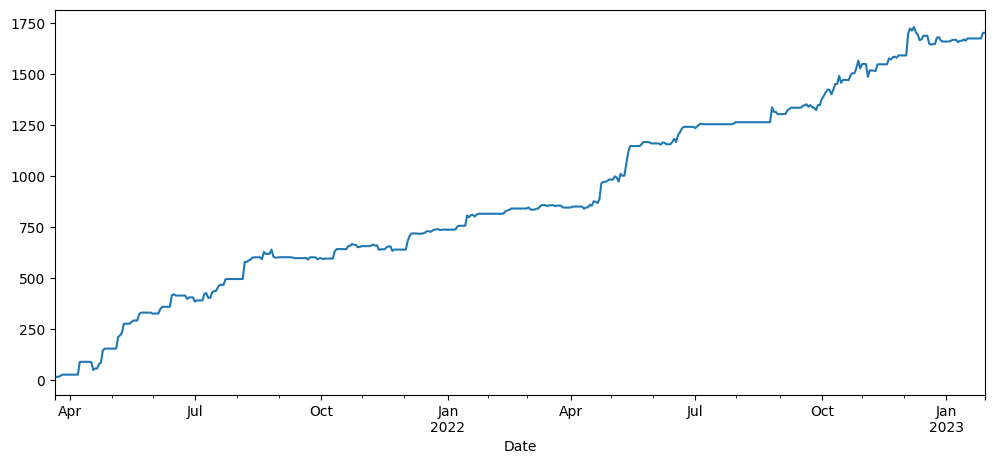

In [28]:
pnl_report.set_index('Date').total_gain.plot(figsize=(12,5))

<AxesSubplot:xlabel='Date'>

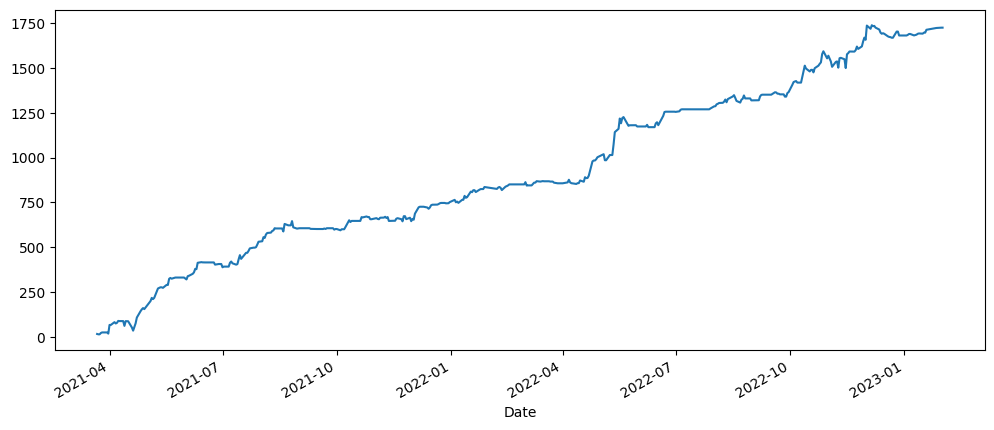

In [29]:
pnl = ((short['Open'].shift(-1) - short['Open'])*short['pos']).cumsum()
pnl.resample('D').last().dropna().plot(figsize=(12,5))

In [14]:
# from datetime import time
# p = pd.DataFrame(short.loc[short['Date'].dt.time.isin([time(10,15),time(14,45)])].sort_values('Date').groupby('Day').apply(lambda x:x['Close'].pct_change())).dropna().reset_index().drop('level_1',axis=1).rename(columns={'Close':'pct'})
# s = pd.DataFrame(short.loc[short['pos']<0]['Day'].unique(),columns=['Day'])
# s['ps'] = -1
# p = p.merge(s,on=['Day'],how='outer')
# p['ps'] = p['ps'].fillna(0)
# p['s'] = p['pct']*p['ps']
# (p.set_index('Day')['s']+1).cumprod().plot()

In [30]:
# pd.Series(profit).sum()
# len(profit)
print('sum: ', pd.Series(profit).sum())
print('len: ', len(profit))
#xac suat thang
d=0
a=0
for i in profit:
    if i > 0:
        d += 1
    if i < 0:
        a += 1
print('win rate: ', d/(d+a))
print('profit:')
s=0
for i in range(1,20):
    print(profit[-i])
    s = s+profit[-i]
print(s)

sum:  1703.499999999987
len:  331
win rate:  0.6344410876132931
profit:
0.22499999999990905
11.625
15.799999999999955
11.324999999999818
-6.875
7.4249999999999545
-0.775000000000091
7.3250000000000455
-4.474999999999909
-7.0
6.4249999999999545
1.9249999999999545
-5.5750000000000455
-16.475000000000023
3.5249999999999773
30.725000000000023
3.0249999999998636
-10.674999999999955
5.9249999999999545
53.424999999999386


In [16]:
def maximum_drawdown_future(backtest):
    max_drawdown = 0
    for i in tqdm(range(1, len(backtest))):
        drawdown = (backtest.rolling(i).max().iloc[i] - backtest.iloc[i])
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown
def sharpe(pnl):
    r = pnl.diff()
    return (r.mean()/r.std() * np.sqrt(252))
print(sharpe(pnl.resample('D').last().dropna()))
print(maximum_drawdown_future(pnl.resample('D').last().dropna()))
print(sharpe(pd.Series(profit).cumsum()))

3.8878726250154414


100%|██████████| 462/462 [00:00<00:00, 3931.24it/s]

93.59999999999854
4.511927089508211
